Analyse Exploratoire

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .appName("Analyse Immatriculations") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

In [3]:
spark.sql("USE concessionnaire")
immatriculation_df = spark.sql("SELECT * FROM immatriculations_data")

immatriculation_df = immatriculation_df.filter(immatriculation_df.immatriculation != "immatriculation")
immatriculation_df.show(20)


+---------------+----------+--------------+---------+-----------+--------+--------+-------+--------+-------+
|immatriculation|    marque|           nom|puissance|   longueur|nbplaces|nbportes|couleur|occasion|   prix|
+---------------+----------+--------------+---------+-----------+--------+--------+-------+--------+-------+
|     3176 TS 67|   Renault|   Laguna 2.0T|      170|     longue|       5|       5|  blanc|   false|27300.0|
|     3721 QS 49|     Volvo|        S80 T6|      272|tr�s longue|       5|       5|   noir|   false|50500.0|
|     9099 UV 26|Volkswagen|  Golf 2.0 FSI|      150|    moyenne|       5|       5|   gris|    true|16029.0|
|     3563 LA 55|   Peugeot|      1007 1.4|       75|     courte|       5|       5|  blanc|    true| 9625.0|
|     6963 AX 34|      Audi|        A2 1.4|       75|     courte|       5|       5|   gris|   false|18310.0|
|     5592 HQ 89|     Skoda| Superb 2.8 V6|      193|tr�s longue|       5|       5|   bleu|   false|31790.0|
|      674 CE 26|  

In [4]:
immatriculation_df.describe().show()

+-------+---------------+-------+---------------+------------------+-----------+--------+------------------+-------+-----------------+
|summary|immatriculation| marque|            nom|         puissance|   longueur|nbplaces|          nbportes|couleur|             prix|
+-------+---------------+-------+---------------+------------------+-----------+--------+------------------+-------+-----------------+
|  count|        2000000|2000000|        2000000|           2000000|    2000000| 2000000|           2000000|2000000|          2000000|
|   mean|           NULL|   NULL|           NULL|       199.0421865|       NULL|     5.0|          4.868432|   NULL|    35782.5696715|
| stddev|           NULL|   NULL|           NULL|137.14856637845043|       NULL|     0.0|0.4958084149033565|   NULL|25775.64060807992|
|    min|        0 AB 42|   Audi|       1007 1.4|                55|     courte|       5|                 3|  blanc|           7500.0|
|    max|     9999 ZU 23|  Volvo|Ypsilon 1.4 16V|      

In [5]:
null_counts = {column: immatriculation_df.filter(F.col(column).isNull()).count() for column in immatriculation_df.columns}
print(null_counts)


{'immatriculation': 0, 'marque': 0, 'nom': 0, 'puissance': 0, 'longueur': 0, 'nbplaces': 0, 'nbportes': 0, 'couleur': 0, 'occasion': 0, 'prix': 0}


In [6]:
immatriculation_df.select("longueur").distinct().show()

+-----------+
|   longueur|
+-----------+
|    moyenne|
|tr�s longue|
|     courte|
|     longue|
+-----------+



In [7]:
immatriculation_df = immatriculation_df.withColumn(
    "longueur",
    F.regexp_replace("longueur", "�", "è")
)
immatriculation_df.select("longueur").distinct().show()



+-----------+
|   longueur|
+-----------+
|    moyenne|
|très longue|
|     courte|
|     longue|
+-----------+



In [8]:
nombre_total_lignes = immatriculation_df.count()
print(nombre_total_lignes)


2000000


In [9]:
# Regrouper par "Immatriculation" et compter le nombre d'occurrences
immatriculation_counts = immatriculation_df.groupBy("Immatriculation").agg(F.count("*").alias("nombre_occurences"))

# Filtrer les enregistrements avec plus d'une occurrence (c'est-à-dire les doublons)
doublons_immatriculation = immatriculation_counts.filter(F.col("nombre_occurences") > 1)

# Afficher les immatriculations en doublon
doublons_immatriculation.show(truncate=False)

+---------------+-----------------+
|Immatriculation|nombre_occurences|
+---------------+-----------------+
|6263 HZ 86     |2                |
|9948 JW 98     |2                |
|5824 ZG 82     |2                |
|7403 LE 20     |2                |
|878 VH 15      |2                |
|5416 GI 61     |2                |
|5104 WX 12     |2                |
|9754 TU 33     |2                |
|8834 LC 47     |2                |
|9008 LB 78     |2                |
|717 CK 69      |2                |
|4977 EB 82     |2                |
|3442 GP 15     |2                |
|1519 WS 31     |2                |
|4374 CN 21     |2                |
|9443 PO 49     |2                |
|6293 PL 76     |2                |
|7660 VO 84     |2                |
|497 GS 33      |2                |
|119 GJ 28      |2                |
+---------------+-----------------+
only showing top 20 rows



In [10]:
nombre_total_lignes = immatriculation_df.count()

doublons_immatriculation = immatriculation_df.groupBy("Immatriculation").count().filter(F.col("count") > 1)

nombre_doublons = doublons_immatriculation.count()
print(nombre_doublons)

pourcentage_doublons = (nombre_doublons / nombre_total_lignes) * 100

print(pourcentage_doublons)

immatriculation_df = immatriculation_df.dropDuplicates(["Immatriculation"])


3366
0.1683


In [11]:
incoherences = immatriculation_df.filter(immatriculation_df['puissance'] < 0)
incoherences.show()


+---------------+------+---+---------+--------+--------+--------+-------+--------+----+
|immatriculation|marque|nom|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|
+---------------+------+---+---------+--------+--------+--------+-------+--------+----+
+---------------+------+---+---------+--------+--------+--------+-------+--------+----+



In [12]:
nombre_de_modeles_et_marques = immatriculation_df.agg(
    F.countDistinct("nom").alias("nombre_de_modeles"),
    F.countDistinct("marque").alias("nombre_de_marques")
)
nombre_de_modeles_et_marques.show()



+-----------------+-----------------+
|nombre_de_modeles|nombre_de_marques|
+-----------------+-----------------+
|               28|               19|
+-----------------+-----------------+



+----------+-----------------+
|    marque|nombre_de_modeles|
+----------+-----------------+
|Volkswagen|                3|
|   Renault|                3|
|    Nissan|                3|
|      Audi|                2|
|  Mercedes|                2|
|       BMW|                2|
|   Peugeot|                1|
|    Jaguar|                1|
|    Lancia|                1|
|       Kia|                1|
|      Mini|                1|
|     Volvo|                1|
|      Saab|                1|
|      Seat|                1|
|     Dacia|                1|
|     Skoda|                1|
|  Daihatsu|                1|
|      Fiat|                1|
|      Ford|                1|
+----------+-----------------+



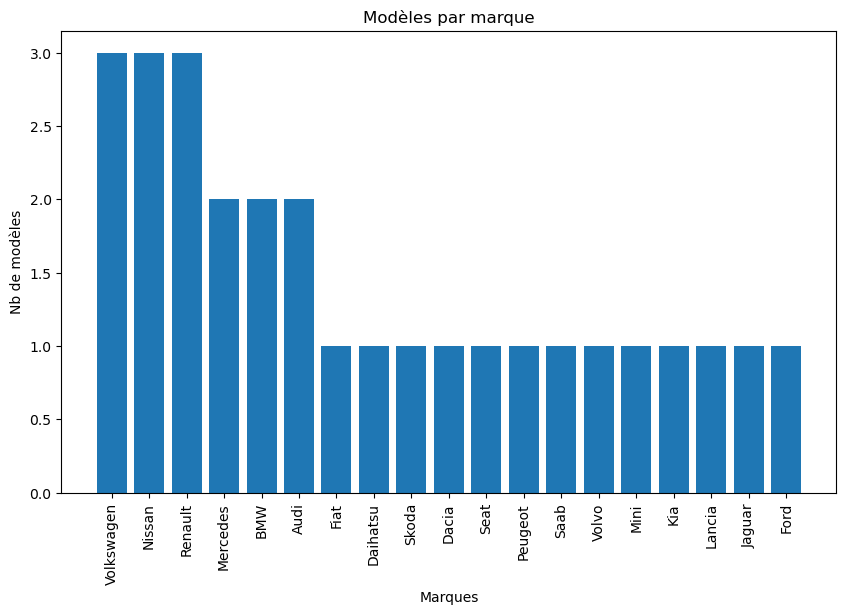

In [13]:
nombre_modeles_par_marque = immatriculation_df.groupBy("marque").agg(
    F.countDistinct("nom").alias("nombre_de_modeles")
)
nombre_modeles_par_marque.orderBy(F.desc("nombre_de_modeles")).show()

#Graph 
nombre_modeles_par_marque_pandas = nombre_modeles_par_marque.toPandas().sort_values(by="nombre_de_modeles", ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(nombre_modeles_par_marque_pandas['marque'], nombre_modeles_par_marque_pandas['nombre_de_modeles'])
plt.xlabel('Marques')
plt.ylabel('Nb de modèles')
plt.title('Modèles par marque')
plt.xticks(rotation=90)
plt.show()




In [14]:
modele_name_extract = F.regexp_extract(F.col("nom"), r'^([A-Za-z0-9\.-]+)', 1)
    
immatriculation_df = immatriculation_df.withColumn("modele", F.trim(modele_name_extract))
    
immatriculation_df = immatriculation_df.drop("nom")

immatriculation_df.show(10, truncate=False)

+---------------+-------+---------+-----------+--------+--------+-------+--------+-------+-------+
|immatriculation|marque |puissance|longueur   |nbplaces|nbportes|couleur|occasion|prix   |modele |
+---------------+-------+---------+-----------+--------+--------+-------+--------+-------+-------+
|0 AJ 71        |Jaguar |197      |longue     |5       |5       |blanc  |true    |25970.0|X-Type |
|0 AW 40        |Peugeot|75       |courte     |5       |5       |gris   |false   |13750.0|1007   |
|0 AX 62        |Volvo  |272      |très longue|5       |5       |blanc  |true    |35350.0|S80    |
|0 BJ 79        |Volvo  |272      |très longue|5       |5       |rouge  |true    |35350.0|S80    |
|0 EZ 80        |Lancia |90       |courte     |5       |3       |gris   |false   |13500.0|Ypsilon|
|0 GK 41        |Audi   |75       |courte     |5       |5       |blanc  |true    |12817.0|A2     |
|0 GU 85        |BMW    |507      |très longue|5       |5       |noir   |false   |94800.0|M5     |
|0 HA 14  

+-----------------+-----------------+
|nombre_de_modeles|nombre_de_marques|
+-----------------+-----------------+
|               28|               19|
+-----------------+-----------------+

+----------+-----------------+
|    marque|nombre_de_modeles|
+----------+-----------------+
|Volkswagen|                3|
|   Renault|                3|
|    Nissan|                3|
|      Audi|                2|
|  Mercedes|                2|
|       BMW|                2|
|   Peugeot|                1|
|    Jaguar|                1|
|    Lancia|                1|
|      Mini|                1|
|       Kia|                1|
|     Volvo|                1|
|      Saab|                1|
|      Seat|                1|
|     Dacia|                1|
|     Skoda|                1|
|  Daihatsu|                1|
|      Fiat|                1|
|      Ford|                1|
+----------+-----------------+



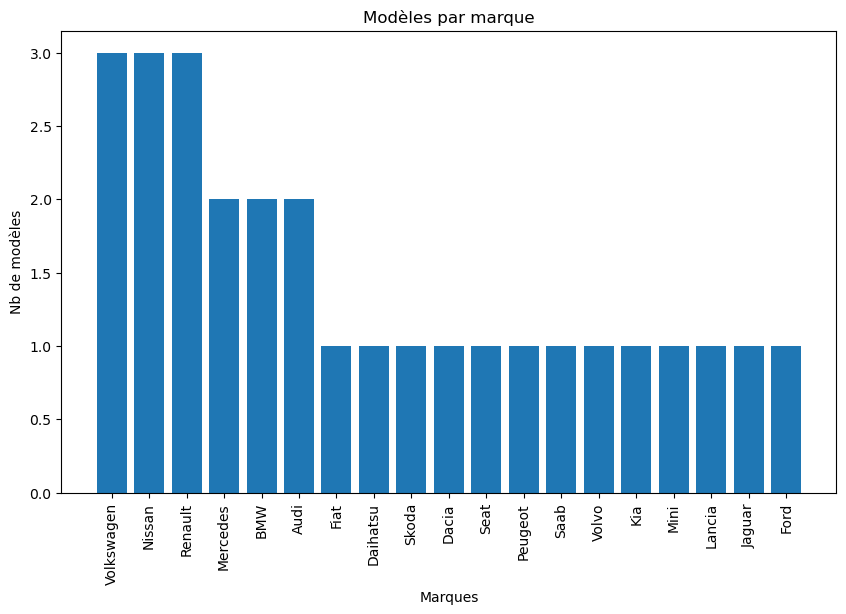

In [15]:
nombre_de_modeles_et_marques = immatriculation_df.agg(
    F.countDistinct("modele").alias("nombre_de_modeles"),
    F.countDistinct("marque").alias("nombre_de_marques")
)
nombre_de_modeles_et_marques.show()

nombre_modeles_par_marque = immatriculation_df.groupBy("marque").agg(
    F.countDistinct("modele").alias("nombre_de_modeles")
)
nombre_modeles_par_marque.orderBy(F.desc("nombre_de_modeles")).show()

#Graph 
nombre_modeles_par_marque_pandas = nombre_modeles_par_marque.toPandas().sort_values(by="nombre_de_modeles", ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(nombre_modeles_par_marque_pandas['marque'], nombre_modeles_par_marque_pandas['nombre_de_modeles'])
plt.xlabel('Marques')
plt.ylabel('Nb de modèles')
plt.title('Modèles par marque')
plt.xticks(rotation=90)
plt.show()

+----------+-------------------------+
|    marque|nombre_d_immatriculations|
+----------+-------------------------+
|       BMW|                   293958|
|      Audi|                   291442|
|   Renault|                   251201|
|    Jaguar|                   188664|
|Volkswagen|                   155727|
|  Mercedes|                   149930|
|     Volvo|                   123615|
|   Peugeot|                    96037|
|      Saab|                    84387|
|      Fiat|                    76490|
|      Ford|                    75702|
|    Nissan|                    68519|
|     Skoda|                    33061|
|       Kia|                    22063|
|  Daihatsu|                    21887|
|      Seat|                    21571|
|      Mini|                    15924|
|     Dacia|                    13954|
|    Lancia|                    12500|
+----------+-------------------------+



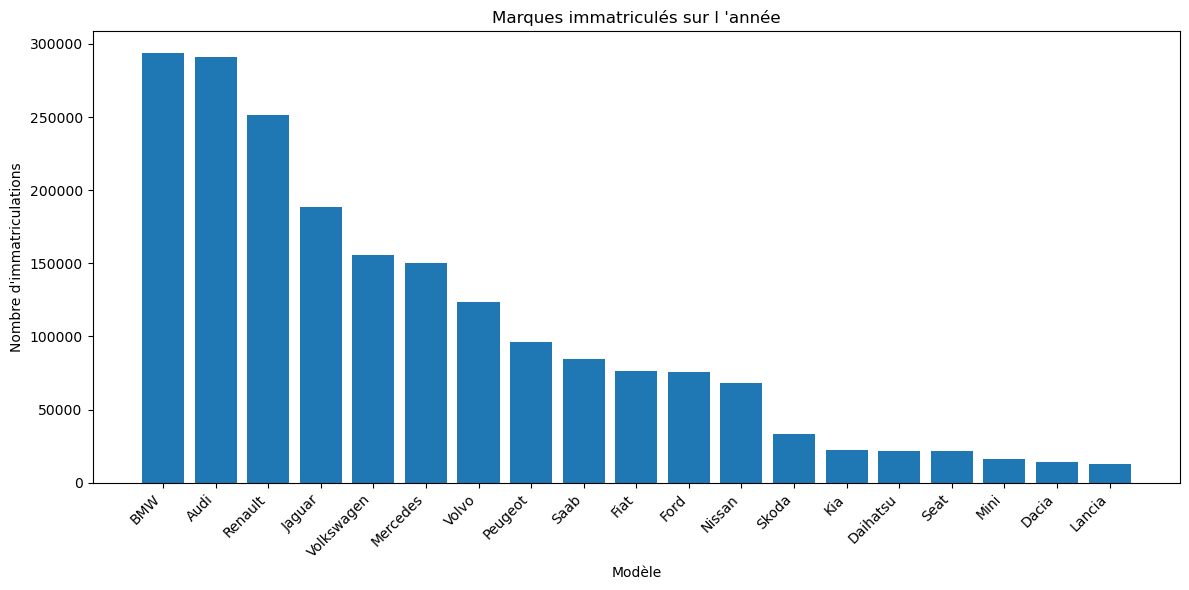

In [16]:
nombre_immatriculations_par_modele = immatriculation_df.groupBy("marque").agg(
    F.count("*").alias("nombre_d_immatriculations")
)
nombre_immatriculations_par_modele.orderBy(F.desc("nombre_d_immatriculations")).show(100)


nombre_immatriculations_par_modele_pandas = nombre_immatriculations_par_modele.orderBy(F.desc("nombre_d_immatriculations")).toPandas()

plt.figure(figsize=(12, 6))
plt.bar(nombre_immatriculations_par_modele_pandas['marque'], nombre_immatriculations_par_modele_pandas['nombre_d_immatriculations'])
plt.xlabel('Modèle')
plt.ylabel('Nombre d\'immatriculations')
plt.title('Marques immatriculés sur l \'année')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

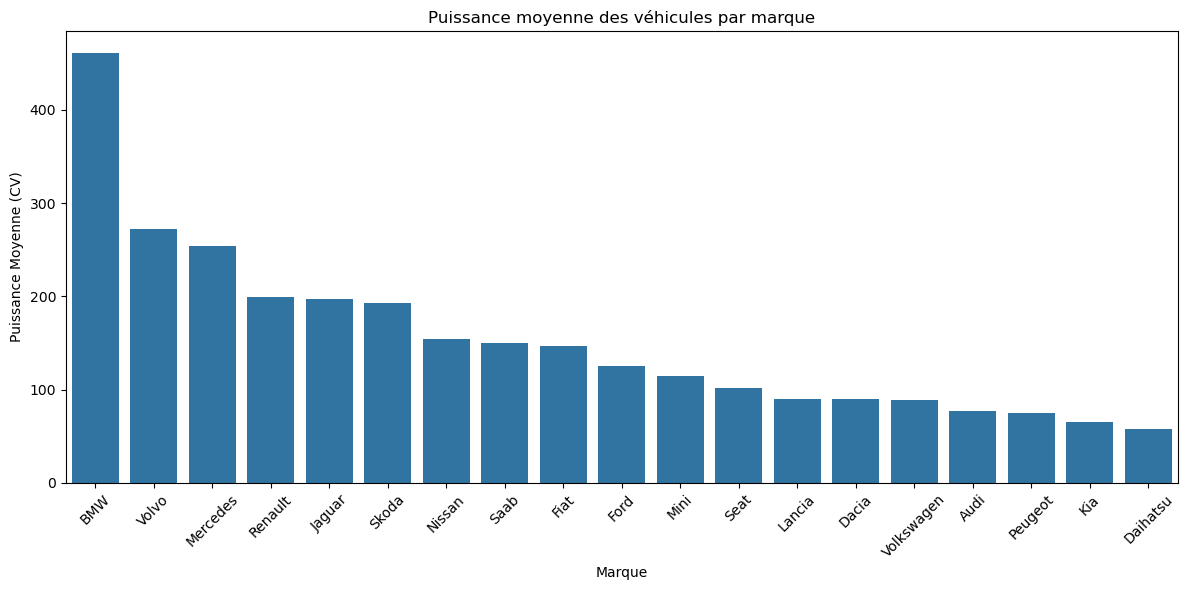

In [17]:
# Calculer la puissance moyenne par marque
puissance_moyenne_par_marque = immatriculation_df.groupBy("marque").agg(
    F.avg("puissance").alias("puissance_moyenne")
)

# Trier par ordre décroissant de la puissance moyenne
puissance_moyenne_par_marque = puissance_moyenne_par_marque.orderBy(F.desc("puissance_moyenne"))

# Convertir en DataFrame Pandas
puissance_moyenne_par_marque_pandas = puissance_moyenne_par_marque.toPandas()


plt.figure(figsize=(12, 6))
sns.barplot(data=puissance_moyenne_par_marque_pandas, x='marque', y='puissance_moyenne')

plt.xlabel('Marque')
plt.ylabel('Puissance Moyenne (CV)')
plt.title('Puissance moyenne des véhicules par marque')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
nombre_immatriculations_par_modele = immatriculation_df.groupBy("nom").agg(
    F.count("*").alias("nombre_d_immatriculations")
)

nombre_immatriculations_par_modele.orderBy(F.desc("nombre_d_immatriculations")).show(100)



AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `nom` cannot be resolved. Did you mean one of the following? [`modele`, `longueur`, `spark_catalog`.`concessionnaire`.`immatriculations_data`.`prix`, `spark_catalog`.`concessionnaire`.`immatriculations_data`.`marque`, `spark_catalog`.`concessionnaire`.`immatriculations_data`.`couleur`].;
'Aggregate ['nom], ['nom, count(1) AS nombre_d_immatriculations#1671L]
+- Project [immatriculation#0, marque#1, puissance#3, longueur#772, nbplaces#5, nbportes#6, couleur#7, occasion#8, prix#9, modele#1179]
   +- Project [immatriculation#0, marque#1, nom#2, puissance#3, longueur#772, nbplaces#5, nbportes#6, couleur#7, occasion#8, prix#9, trim(regexp_extract(nom#2, ^([A-Za-z0-9\.-]+), 1), None) AS modele#1179]
      +- Deduplicate [immatriculation#0]
         +- Project [immatriculation#0, marque#1, nom#2, puissance#3, regexp_replace(longueur#4, �, è, 1) AS longueur#772, nbplaces#5, nbportes#6, couleur#7, occasion#8, prix#9]
            +- Filter NOT (immatriculation#0 = immatriculation)
               +- Project [immatriculation#0, marque#1, nom#2, puissance#3, longueur#4, nbplaces#5, nbportes#6, couleur#7, occasion#8, prix#9]
                  +- SubqueryAlias spark_catalog.concessionnaire.immatriculations_data
                     +- HiveTableRelation [`spark_catalog`.`concessionnaire`.`immatriculations_data`, org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe, Data Cols: [immatriculation#0, marque#1, nom#2, puissance#3, longueur#4, nbplaces#5, nbportes#6, couleur#7, ..., Partition Cols: []]


In [ ]:

immatriculations_par_longueur = immatriculation_df.groupBy("longueur").agg(
    F.count("*").alias("nombre_d_immatriculations")
)

immatriculations_par_longueur = immatriculations_par_longueur.orderBy(F.desc("nombre_d_immatriculations"))
immatriculations_par_longueur.show()

immatriculations_par_longueur_pandas = immatriculations_par_longueur.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(
    immatriculations_par_longueur_pandas['nombre_d_immatriculations'], 
    labels=immatriculations_par_longueur_pandas['longueur'], 
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('muted'),
)
plt.title('Immatriculations par catégorie de longueur')
plt.tight_layout()
plt.show()



In [ ]:
immatriculations_par_longueur = immatriculation_df.groupBy("occasion").agg(
    F.count("*").alias("nombre_d_immatriculations")
)

immatriculations_par_longueur = immatriculations_par_longueur.orderBy(F.desc("nombre_d_immatriculations"))
immatriculations_par_longueur.show()

#Graph
immatriculations_par_longueur_pandas = immatriculations_par_longueur.toPandas()
immatriculations_par_longueur_pandas['label'] = immatriculations_par_longueur_pandas['occasion'].apply(
    lambda x: "Occasion" if x else "Neuf"
)

plt.figure(figsize=(8, 8))
plt.pie(
    immatriculations_par_longueur_pandas['nombre_d_immatriculations'], 
    labels=immatriculations_par_longueur_pandas['label'], 
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('muted'),
)
plt.title('Immatriculations par catégorie de longueur')
plt.tight_layout()
plt.show()

In [ ]:
data_sample = immatriculation_df.sample(fraction=0.1).toPandas()
numerical_data = data_sample.select_dtypes(include=['float64', 'float32', 'int64', 'int32'])
corr_matrix = numerical_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Corrélation sur les champs numériques")
plt.show()
